In [1]:
#Bibliotecas
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
import time
from scipy.ndimage import zoom, gaussian_filter
import random
from sklearn.model_selection import train_test_split
from scipy.ndimage import rotate
from numpy.random import choice
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.activations import elu
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import time
import tensorflow as tf
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, brier_score_loss, classification_report
from matplotlib.colors import LogNorm
import seaborn as sns
from tensorflow import keras

In [2]:
start_time = time.time()
datafile_path = r"C:\Users\Cliente\Documents\TCC NATALI\hlsp_deepmerge_hst_acs-wfc3_illustris-z2_f814w-f160w_v1_sim-pristine.fits"

hdulist = fits.open(datafile_path)
header = hdulist[0].header

X = np.array(hdulist[0].data)
Y = np.array(hdulist[1].data)

t_file_read = time.time()-start_time
print("tempo para ler dados do arquivo: {:0.3f} s".format(t_file_read))

shape_hdu0 = X.data.shape
shape_hdu1 = Y.shape
print(f"Shape do HDU0 (Images): {shape_hdu0}")
print(f"Shape do HDU1 (Label): {shape_hdu1}")

tempo para ler dados do arquivo: 2.556 s
Shape do HDU0 (Images): (15426, 2, 75, 75)
Shape do HDU1 (Label): (15426,)



Exemplo de imagens por filtros:

[11604  6546]



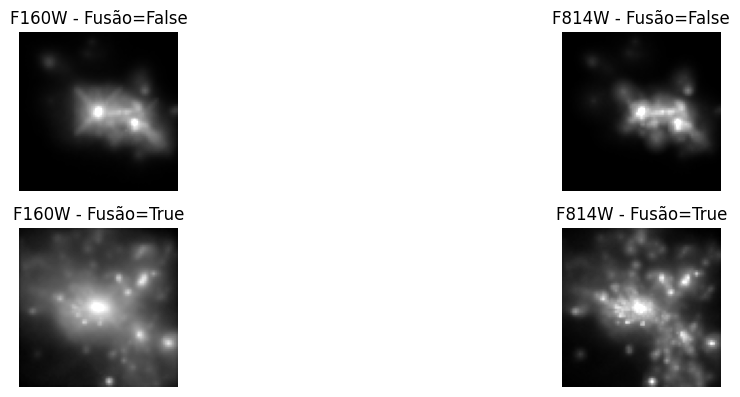

In [3]:
plot_sample_images = True
np.random.seed(206265)

examples_f160w = [hdulist[0].data[j, 1, :, :] for j in range(shape_hdu0[0])]
examples_f814w = [hdulist[0].data[j, 0, :, :] for j in range(shape_hdu0[0])]

if plot_sample_images:
    example_ids = np.random.choice(len(hdulist[0].data), 2)  # Seleciona 4 IDs aleatórios
    print("\nExemplo de imagens por filtros:\n")
    print(f'{example_ids}\n')

    # F160W filtro  no infravermelho próximo a luz visível ~ 840 nm (NIR)
    # F814W filtro no infravermelho ~ 1600nm  (FIR)

    fig = plt.figure(figsize=(11, 8))

    # Criando um loop para mostrar cada imagem com o respectivo rótulo
    for i, example_id in enumerate(example_ids):
        # F160W
        ax1 = fig.add_subplot(4, 2, (i * 2) + 1)  # Use (i * 2) + 1 como índice
        norm1 = simple_norm(hdulist[0].data[example_id, 1, :, :], 'log', max_percent=99.75)  # Acessa imagem correta
        ax1.imshow(hdulist[0].data[example_id, 1, :, :], aspect='equal', cmap='gray', norm=norm1)
        ax1.set_title('F160W - Fusão=' + str(bool(Y[example_id])))  # Usa o rótulo correto
        ax1.axis('off')

        # F814W
        ax2 = fig.add_subplot(4, 2, (i * 2) + 2)  # Use (i * 2) + 2 como índice
        norm2 = simple_norm(hdulist[0].data[example_id, 0, :, :], 'log', max_percent=99.75)  # Acessa imagem correta
        ax2.imshow(hdulist[0].data[example_id, 0, :, :], aspect='equal', cmap='gray', norm=norm2)
        ax2.set_title('F814W - Fusão=' + str(bool(Y[example_id])))  # Usa o rótulo correto
        ax2.axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
data_hdu1_vec = np.array([y[0] for y in Y])
list_of_mergers = np.where(data_hdu1_vec == 1.)[0]
list_of_nonmergers = np.where(data_hdu1_vec == 0.)[0]

print(f"Shape de list_of_mergers (label = 1): {list_of_mergers.shape}")
print(f"Shape de list_of_nonmergers (label = 0): {list_of_nonmergers.shape}")

Shape de list_of_mergers (label = 1): (8120,)
Shape de list_of_nonmergers (label = 0): (7306,)


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the proportions:
train_ratio = 0.7
validation_ratio = 0.1
test_ratio = 0.2

# Round the sum to ensure it equals 1.0
rounded_sum = round(train_ratio + validation_ratio + test_ratio, 10)  # Adjust decimal places as needed
assert rounded_sum == 1.0

# Divide os dados em treino e (teste + validação)
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X, Y, test_size=(validation_ratio + test_ratio), random_state=42, shuffle=True, stratify=Y
)

# Divide o conjunto temporário em teste e validação
X_validation, X_test, Y_validation, Y_test = train_test_split(
    X_temp, Y_temp, test_size=test_ratio / (validation_ratio + test_ratio), random_state=42, shuffle=True, stratify=Y_temp
)

print("Tamanho do conjunto de treinamento:", X_train.shape[0])
print("Tamanho do conjunto de validação:", X_validation.shape[0])
print("Tamanho do conjunto de teste:", X_test.shape[0])

Tamanho do conjunto de treinamento: 10798
Tamanho do conjunto de validação: 1542
Tamanho do conjunto de teste: 3086


In [6]:
#Calcula a média e o desvio padrão do conjunto de treinamento.
#Normaliza os dados de treinamento, validação e teste utilizando a média e o desvio padrão do conjunto de treinamento.
mean_train = np.mean(X_train)
std_train = np.std(X_train)

X_train = (X_train - mean_train) / std_train
X_validation = (X_validation - mean_train) / std_train
X_test = (X_test - mean_train) / std_train

In [12]:
#Arquitetura da rede

t_NN_creation = time.time()

# Arquitetura da Rede (com as melhorias)
input_shape = (2, 75, 75) 

input_tensor = layers.Input(shape=input_shape)

x = layers.Conv2D(32, (5, 5), activation=elu, strides=(1, 1), padding='same', data_format='channels_first')(input_tensor)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(x) 
x = layers.Dropout(0.4)(x) 

x = layers.Conv2D(64, (3, 3), activation=elu, strides=(1, 1), padding='same', data_format='channels_first')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(x)
x = layers.Dropout(0.4)(x) 

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.05))(x) 
x = layers.Dropout(0.4)(x)
x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.05))(x) 
x = layers.Dropout(0.4)(x)

output_tensor = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=input_tensor, outputs=output_tensor)

# Compilação do Modelo
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
metrics = ['accuracy']
loss = 'binary_crossentropy'

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2, 75, 75)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 75, 75)          │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 75, 75)          │             300 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 37, 37)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32, 37, 37)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 37, 37)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 37, 37)          │             148 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 18, 18)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64, 18, 18)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       2,654,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,679,073 (10.22 MB)

 Trainable params: 2,678,849 (10.22 MB)

 Non-trainable params: 224 (896.00 B)

None


In [13]:
checkpoint_filepath = 'melhor_modelo_pesos.weights.keras'

checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10,
    restore_best_weights=True
)

callbacks = [checkpoint, early_stopping]

In [14]:
epoch = 100
batch_size = 128
shuffle = True

X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
Y_train = np.asarray(Y_train).astype('float32')
Y_test = np.asarray(Y_test).astype('float32')
X_validation = np.asarray(X_validation).astype('float32')
Y_validation = np.asarray(Y_validation).astype('float32')

In [15]:
training_time = time.time()

history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=batch_size,
    epochs=epoch,
    validation_data=(X_validation, Y_validation),
    shuffle=shuffle,
    verbose=1,
    callbacks=callbacks
)

training_time =  time.time()-training_time
print("tempo para treinamento da rede: {:0.3f} s".format(training_time))

tempo_total = time.time() - start_time
print("tempo total: {:0.3f} s".format(tempo_total))

accuracy = model.evaluate(X_test, Y_test, verbose=0)[1]
print(f"Acurácia do modelo carregado: {accuracy * 100:.2f}%")

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5107 - loss: 14.8162
Epoch 1: val_accuracy improved from -inf to 0.52789, saving model to melhor_modelo_pesos.weights.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.5107 - loss: 14.8001 - val_accuracy: 0.5279 - val_loss: 10.9359
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5208 - loss: 10.2211
Epoch 2: val_accuracy improved from 0.52789 to 0.53243, saving model to melhor_modelo_pesos.weights.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.5208 - loss: 10.2128 - val_accuracy: 0.5324 - val_loss: 8.1306
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5412 - loss: 7.6767
Epoch 3: val_accuracy did not improve from 0.53243
85/85 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.5412 - loss: 7.6718 - val_accuracy: 0.5279 - val_loss: 6.4018
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5380 - loss: 6.1063
Epoch 4: val_accuracy did not improve from 0.53243
8

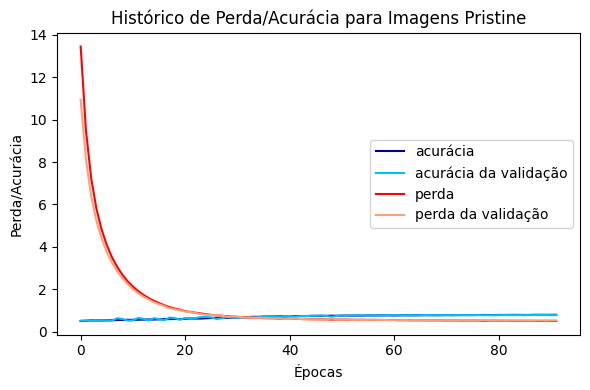

In [17]:
## Gráficos do histórico de treinamento
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = list(range(len(loss)))
figsize = (6, 4)
fig, axis1 = plt.subplots(figsize=figsize)

plot1_lacc = axis1.plot(epochs, acc, 'navy', label='acurácia')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="acurácia da validação")

plot1_loss = axis1.plot(epochs, loss, 'red', label='perda')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="perda da validação")

#plots = plot1_loss + plot1_val_loss + plot1_lacc + plot1_val_lacc
plots = plot1_loss+plot1_lacc
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Épocas')
axis1.set_ylabel('Perda/Acurácia')
plt.title("Histórico de Perda/Acurácia para Imagens Pristine")
plt.tight_layout()
axis1.legend(loc='center right')

plt.show()

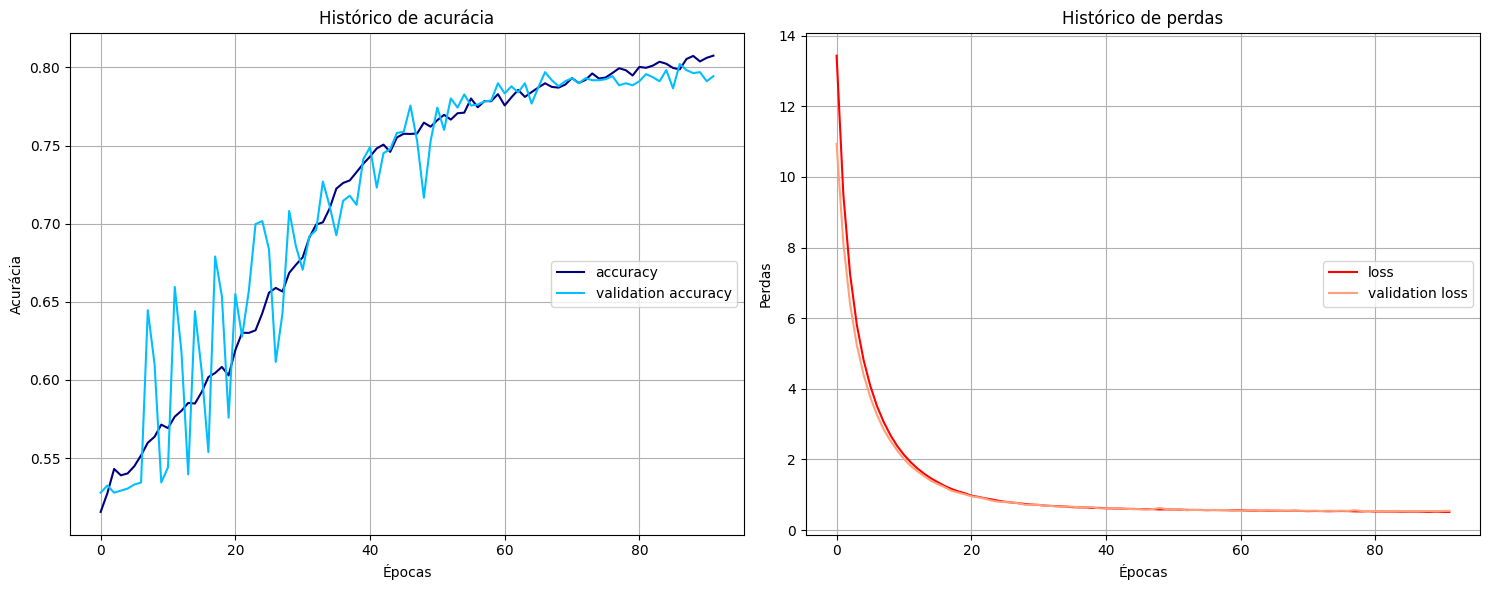

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = list(range(len(loss)))
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axis1 = axs[0]
axis2 = axs[1]

axis1.plot(epochs, acc, 'navy', label='accuracy')
axis1.plot(epochs, val_acc, 'deepskyblue', label="validation accuracy")

axis2.plot(epochs, loss, 'red', label='loss')
axis2.plot(epochs, val_loss, 'lightsalmon', label="validation loss")

axis1.set_xlabel('Épocas')
axis1.set_ylabel('Acurácia')
axis1.legend(loc='center right')
axis1.grid(True)

axis2.set_xlabel('Épocas')
axis2.set_ylabel('Perdas')
axis2.legend(loc='center right')
axis2.grid(True)

axis1.set_title("Histórico de acurácia")
axis2.set_title("Histórico de perdas")

plt.tight_layout()
plt.show()

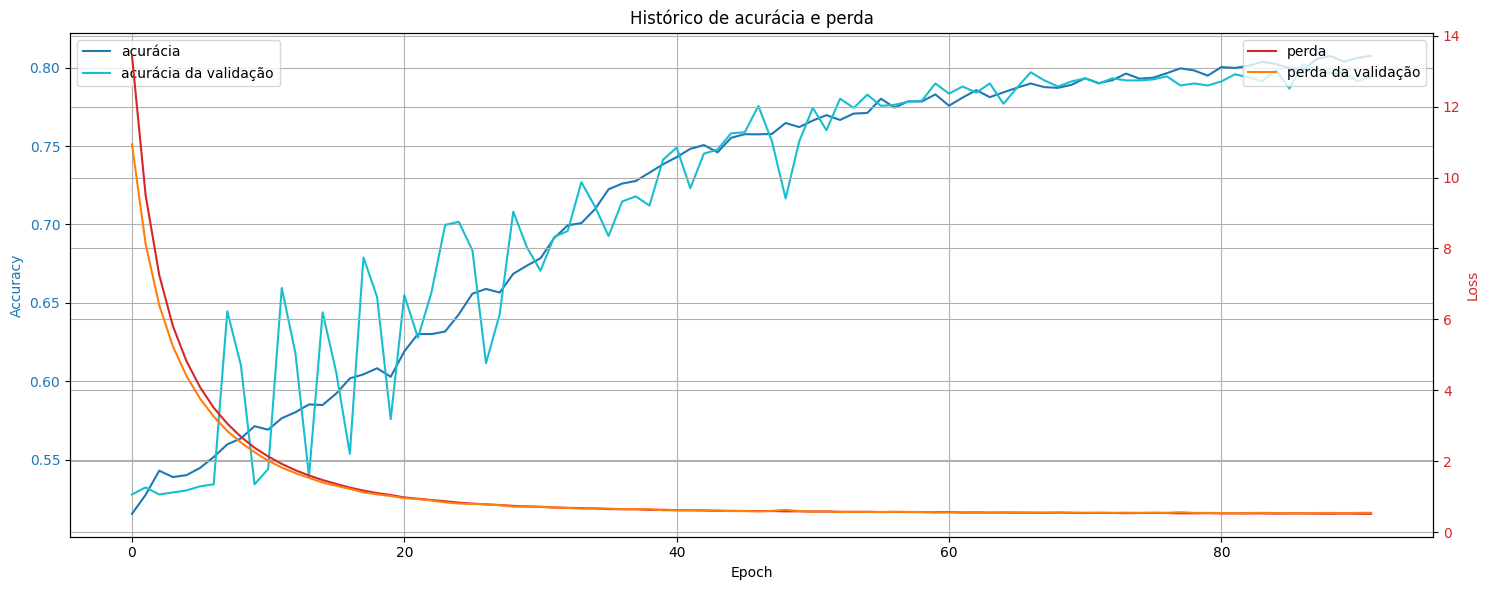

In [19]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = list(range(len(loss)))

fig, ax1 = plt.subplots(figsize=(15, 6))

# Accuracy and Validation Accuracy (left y-axis)
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(epochs, acc, color=color, label='acurácia')
ax1.plot(epochs, val_acc, color='tab:cyan', label="acurácia da validação")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.grid(True)

# Loss and Validation Loss (right y-axis)
ax2 = ax1.twinx()  # Create a twin axis
color = 'tab:red'
ax2.set_ylabel('Loss', color=color)
ax2.plot(epochs, loss, color=color, label='perda')
ax2.plot(epochs, val_loss, color='tab:orange', label="perda da validação")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')
ax2.grid(True)

plt.title("Histórico de acurácia e perda")
plt.tight_layout()
plt.show()

In [20]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Acurácia no conjunto de teste:', accuracy)
print('Perda no conjunto de teste:', loss)

Acurácia no conjunto de teste: 0.7945560812950134
Perda no conjunto de teste: 0.5410548448562622


97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step
cm [[1214.  248.]
 [ 386. 1238.]]
cm_norm [[0.83036936 0.16963064]
 [0.23768473 0.76231527]]
AUC: 0.8734930219080416


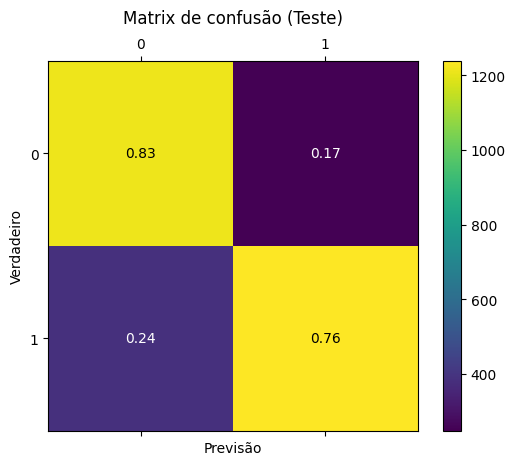

In [21]:
# ------------------------------------------------------------------------------
# Evaluate for TEST SET  ---> REPLICAR
# ------------------------------------------------------------------------------

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# predict
history_data = history
prob = model.predict(X_test)
pred =  (prob > 0.5).astype('int32') 

# measure confusion
labels=[0, 1]
cm = confusion_matrix(Y_test, pred, labels=labels)
cm = cm.astype('float')
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
print("cm", cm)
print("cm_norm", cm_norm)

# Corrigindo a importação
fpr, tpr, thresholds = roc_curve(Y_test, prob, pos_label=1)
auc = roc_auc_score(Y_test, prob)
print("AUC:", auc)

#plotting
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Matrix de confusão (Teste)', y=1.08)
fig.colorbar(cax)

# Definir ticks antes de definir os rótulos
ax.set_xticks(range(len(labels)))  # Definir ticks para o eixo x
ax.set_yticks(range(len(labels)))  # Definir ticks para o eixo y

# Definir rótulos dos ticks
ax.set_xticklabels(labels)  # Remova o rótulo extra
ax.set_yticklabels(labels)

plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
fmt = '.2f'
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], fmt),
        ha="center", va="center",
        color="white" if cm_norm[i, j] < thresh else "black")
plt.show()

97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step


Text(792.3131313131312, 0.5, 'Verdadeiro')

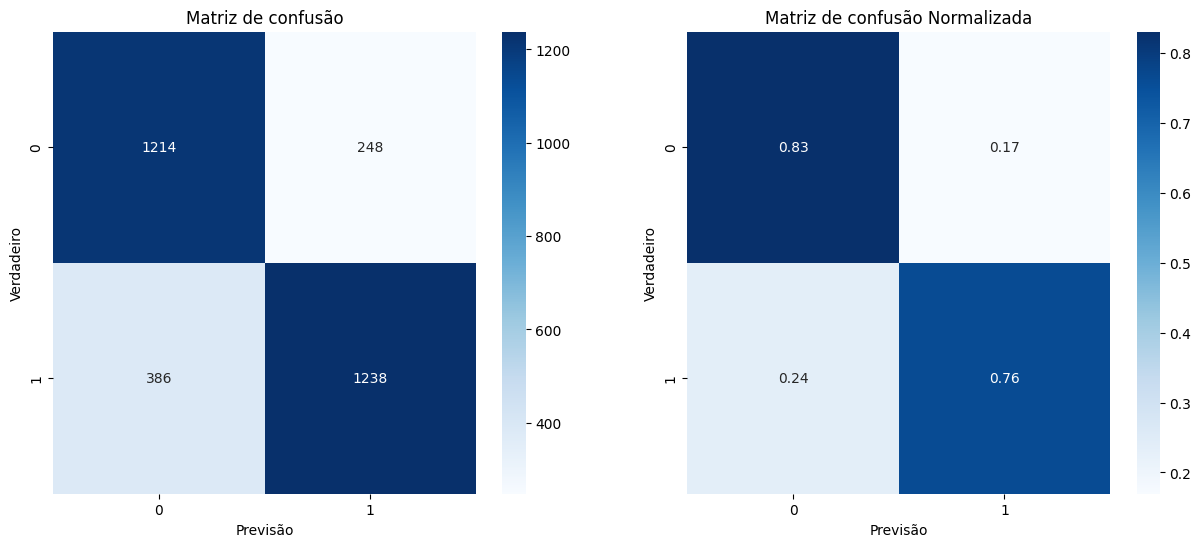

In [22]:
history_data = history
prob = model.predict(X_test)
pred =  (prob > 0.5).astype('int32')

labels=[0, 1]
cm = confusion_matrix(Y_test, pred[:,0], labels=labels)
cm_norm = cm.astype(float) / cm.astype(float).sum(axis=1)[:, np.newaxis]

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=axs[0])
axs[0].set_title('Matriz de confusão')
axs[0].set_xlabel('Previsão')
axs[0].set_ylabel('Verdadeiro')

sns.heatmap(cm_norm, annot=True, cmap='Blues', ax=axs[1])
axs[1].set_title('Matriz de confusão Normalizada')
axs[1].set_xlabel('Previsão')
axs[1].set_ylabel('Verdadeiro')

In [23]:
#Parametros ---> REPLICAR

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(Y_test, pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(Y_test, pred)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, pred)
print('F1 score: %f' % f1)

# brier score
bs = brier_score_loss(Y_test, prob)
print('Brier score: %f' % bs)

Accuracy: 0.794556
Precision: 0.833109
Recall: 0.762315
F1 score: 0.796141
Brier score: 0.145692



 AUC: 0.8734930219080416


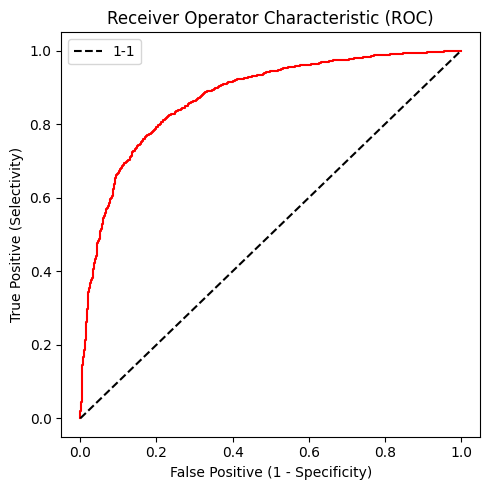

In [24]:
fpr, tpr, thresholds = roc_curve(Y_test, prob, pos_label=1)
auc = roc_auc_score(Y_test, prob)
print("\n AUC:", auc)

figsize=(5,5)
fig, axis1 = plt.subplots(figsize=figsize)
x_onetoone = y_onetoone = [0, 1]
plt.plot(fpr, tpr, 'r-')
plt.plot(x_onetoone, y_onetoone, 'k--',  label="1-1")
plt.legend(loc=0)
plt.title("Receiver Operator Characteristic (ROC)")
plt.xlabel("False Positive (1 - Specificity)")
plt.ylabel("True Positive (Selectivity)")
plt.tight_layout() 

In [25]:
bs = brier_score_loss(Y_test, prob)
print('Brier score: %f' % bs)

print('\n', classification_report(Y_test, pred))

Brier score: 0.145692

               precision    recall  f1-score   support

         0.0       0.76      0.83      0.79      1462
         1.0       0.83      0.76      0.80      1624

    accuracy                           0.79      3086
   macro avg       0.80      0.80      0.79      3086
weighted avg       0.80      0.79      0.79      3086



In [26]:
import numpy as np
import random

# ... (seu código que define model, X_test, Y_test)

# Fazer previsões e calcular o erro
prob = model.predict(X_test)
pred = (prob > 0.5).astype("int32")
Pred_error = pred[:, 0] - Y_test

random.seed(2024)  # Define a semente ANTES da amostragem
num_samples = len(X_test) #  Usar todos os dados com a seed fixa

indices = random.sample(range(len(X_test)), num_samples) # Embaralha os índices com a seed

# Cria listas vazias para armazenar os índices de cada classe
FN_indices = []
FP_indices = []
TN_indices = []
TP_indices = []

# Classifica os índices com base nas previsões e nos valores reais
for i in indices:
    if Pred_error[i] == 1:
        FN_indices.append(i)
    elif Pred_error[i] == -1:
        FP_indices.append(i)
    elif (Y_test[i] + pred[i, 0]) == 0:
        TN_indices.append(i)
    elif (Y_test[i] + pred[i, 0]) == 2:
        TP_indices.append(i)



# Calcula e imprime as porcentagens
print(
    f"Número de FN, FP, TN, TP = {len(FN_indices)}, {len(FP_indices)}, {len(TN_indices)}, {len(TP_indices)}",
    end=" ",
)
print(
    "({:.1f}%, {:.1f}%, {:.1f}%, {:.1f}%)".format(
        100 * len(FN_indices) / num_samples,
        100 * len(FP_indices) / num_samples,
        100 * len(TN_indices) / num_samples,
        100 * len(TP_indices) / num_samples,
    )
)



# Agora você tem as listas FN_indices, FP_indices, TN_indices e TP_indices
# contendo os índices correspondentes a cada classe, usando a ordem 
# aleatória definida pela seed(42).

97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step
Número de FN, FP, TN, TP = 248, 386, 1214, 1238 (8.0%, 12.5%, 39.3%, 40.1%)


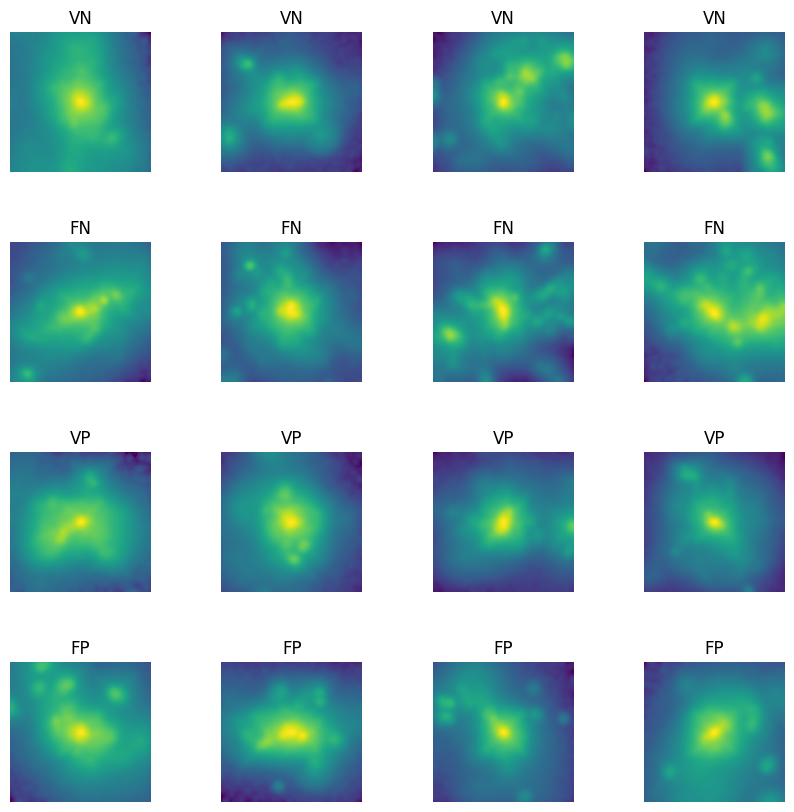

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm
import random

# ... (seu código que define model, X_test, Y_test)

# Fazer previsões e calcular o erro, etc. (mesmo código do bloco anterior)
# ...


#  (Removido: Dicionários examples e example_indices - não são mais necessários)


# Plota os exemplos usando os índices calculados anteriormente
all_examples = []
classificacoes = []


indices_por_classe = {
    'VN': TN_indices, 
    'FN': FN_indices,
    'VP': TP_indices,
    'FP': FP_indices,
}


for classe, indices in indices_por_classe.items():
    all_examples.extend([X_test[i, 1] for i in indices[:4]]) # Seleciona até 4 exemplos de cada classe
    classificacoes.extend([classe] * min(4, len(indices))) # Adiciona a classificação correta


fig1, axes = plt.subplots(4, 4, figsize=(10, 10))
fig1.subplots_adjust(hspace=0.5, wspace=0.5)

for i, (image, classe) in enumerate(zip(all_examples, classificacoes)):
    random.seed(2024 + i)  # Define uma semente para reprodutibilidade, mas não afeta a seleção

    ax = axes.flat[i]
    ax.axis("off")

    # Normaliza e aplica filtro Gaussiano
    image = (image - image.min()) / (image.max() - image.min() + 1e-8)
    image = gaussian_filter(image, sigma=1)

    ax.imshow(image, aspect='auto', cmap='viridis', norm=LogNorm())
    ax.set_title(classe)

plt.show()

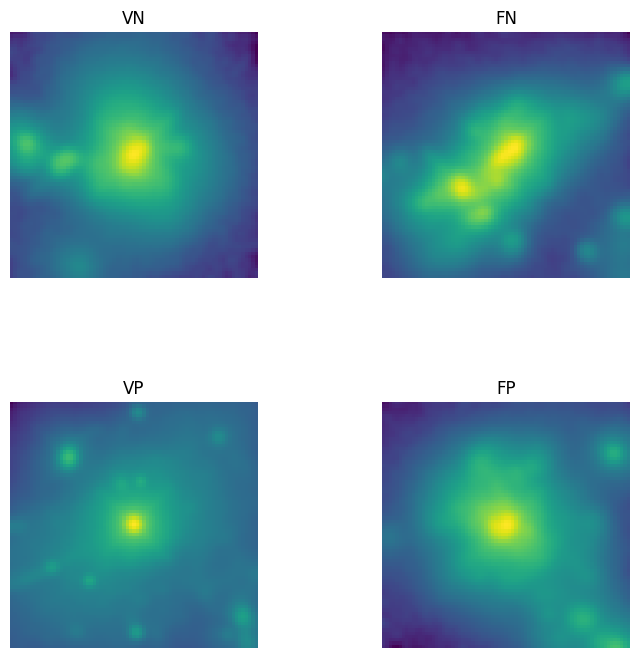

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm
import random

# ... (seu código anterior, incluindo a definição de model, X_test, Y_test,
# o cálculo das previsões e a criação dos índices *_indices)

# ...


# Plota exemplos aleatórios, duas imagens por linha, com tamanho menor
num_classes = len(indices_por_classe)
fig1, axes = plt.subplots(num_classes // 2, 2, figsize=(8, 4 * (num_classes // 2)))  # Tamanho menor
fig1.subplots_adjust(hspace=0.5, wspace=0.5)

all_examples = []
classificacoes = []

rng = random.Random(2024) # Gerador de números aleatórios com semente fixa


for classe, indices in indices_por_classe.items():
    if indices: # Verifica se há exemplos para a classe.
        random_index = rng.choice(indices) # Seleciona um índice ALEATÓRIO
        all_examples.append(X_test[random_index, 1])
        classificacoes.append(classe)
    else:
        print(f"Nenhum exemplo encontrado para a classe {classe}. Pulando.")


for i, (image, classe) in enumerate(zip(all_examples, classificacoes)):
    ax = axes.flat[i]
    ax.axis("off")

    # Normaliza e aplica filtro Gaussiano
    image = (image - image.min()) / (image.max() - image.min() + 1e-8)
    image = gaussian_filter(image, sigma=1)

    ax.imshow(image, aspect='auto', cmap='viridis', norm=LogNorm())
    ax.set_title(classe)

plt.show()